# Model Reproducibility
In this notebook I will reproduce the figures from the [SolTranNet](../papers/eos6oli.pdf) publication associated to the model and make sure the Ersilia Model Hub implementation is giving the same results.
I obtained the predictions dataset from the publication on [Github](https://github.com/francoep/SolTranNet_paper/blob/main/soltrannet_data.tar.gz)

In [76]:
# import necessary libraries, packages and file paths

import tarfile
import os
import sys
import glob


import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

sys.path.append('../src')
from predicted_stats import calculate_statistics

extract_dir = '../data/soltranet'
tar_gz_file = '../data/soltrannet_data.tar.gz'
predictions_file = '../data/soltranet/data/llinas2020/soltrannet/llinas_final_aq_model.predictions'



In [13]:
# Unzip the .tar.gz file with the data

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with tarfile.open(tar_gz_file, 'r:gz') as tar:
    tar.extractall(path=extract_dir)

In [20]:
# Load the file with the predictions data from the /data folder
predictions = pd.read_csv(predictions_file)
predictions

,smile,true,pred
0,CC(NC1=NN=C(S1)[S](N)(=O)=O)=O,-2.38,-1.237027
1,C(C)(=O)OC1=CC=CC=C1C(=O)O,-1.67,-1.853987
2,C=CCOc1ccc(cc1Cl)CC(=O)O,-4.40,-3.101205
3,O[C@@H]2CC[C@@H](NCc1cc(Br)cc(Br)c1N)CC2,-3.87,-2.252857
4,O=C1Nc2c(ccc(OCCCCN3CCN(c4c(Cl)c(Cl)ccc4)CC3)c...,-6.64,-5.010855
...,...,...,...
127,C1=C(N=C(N=C1N[S](C2=CC=C(N)C=C2)(=O)=O)OC)OC,-3.74,-3.677886
128,C1=CC(=CC=C1\C(=C(C2=CC=CC=C2)\CC)C3=CC=CC=C3)...,-7.52,-5.451304
129,CCCc1nc2c(cc(cc2n1Cc3ccc(cc3)c4ccccc4C(=O)O)c5...,-6.73,-7.617531
130,C1=CC=CC=C1C(C3CCN(CCCC(C2=CC=C(C(C)(C)C)C=C2)...,-7.74,-4.817547


## Reproduce the figures on the SolTranNet Publication.

## a) Distribution of True Log Solubility of Compounds

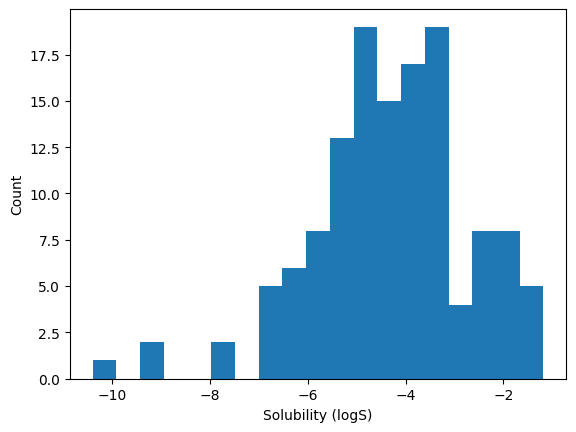

In [50]:
# Create histogram of the distribution of the true log solubility in the compounds

truth = predictions['true']
w=0.5
n=math.ceil((max(truth)-min(truth))/w)


plt.hist(truth,bins=n);
plt.xlabel('Solubility (logS)');
plt.ylabel('Count');
plt.savefig('../figures/Distribution of True Log Solubility from SolTranNet Publication.png')

## b) Sensitivity and False Discovery Rate Analysis

From the publication, a soluble compound is one that has logS > -4.

Define a relaxed log solubility threshold with the lower solubility threshold being -6 and the higher log solubility threshold being -6.

The function ``calculate_statistics`` is used to calculate the percentage of the correctly and incorrectly predicted statistics based on predicted and true solubilities.

In [111]:
#calculate statistics for SolTranNet predictions
data={}

truths=np.array([])
preds=np.array([])

truths=np.append(truths,predictions['true'])
preds=np.append(preds,predictions['pred'])

for val in [-4,-5,-6]:
    data[val]={'hit':[],'miss':[]}
    hit,miss,no_truths,no_preds=calculate_statistics(preds,truths,val,-4)
    data[val]['hit']=[('SolTranNet',hit)]
    data[val]['miss']=[('SolTranNet',miss)]

In [113]:
# calculate statistics for other predictions
all_files=glob.glob('../data/soltranet/data/llinas2020/submitted/*.csv')

keys=set([x.split('/')[-1].split('_set')[0] for x in all_files])

for val in [-4,-5,-6]:
    for k in keys:
        truths = np.array([])
        preds = np.array([])
        file = glob.glob(f'../data/soltranet/data/llinas2020/submitted/{k}*.csv')

        for fname in file:
            file_df=pd.read_csv(fname)
            truths=np.append(truths,file_df['TRUE'])
            preds=np.append(preds,file_df['PREDICTED'])
            
        hit,miss,nt,nul = calculate_statistics(preds,truths,val,-4)
        data[val]['hit'].append((k,hit))
        data[val]['miss'].append((k,miss))

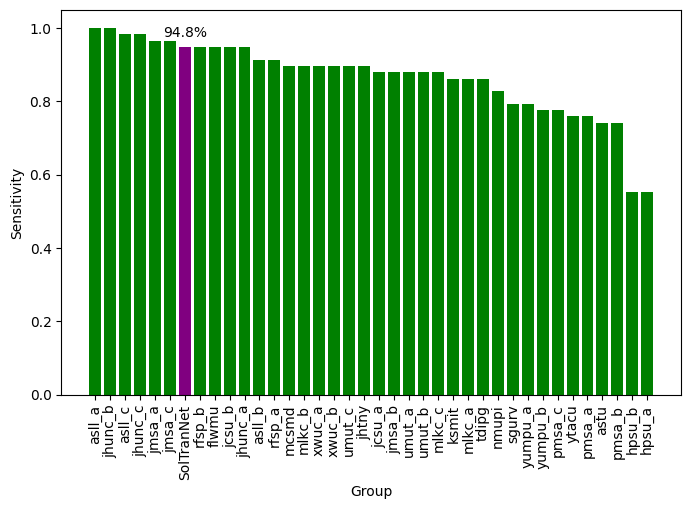

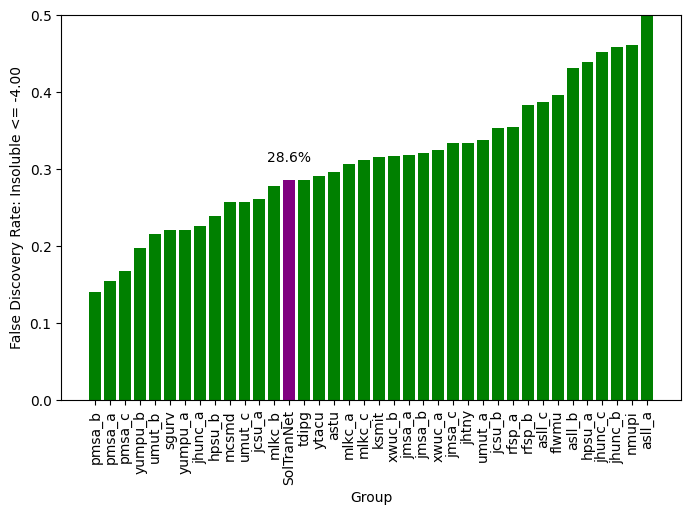

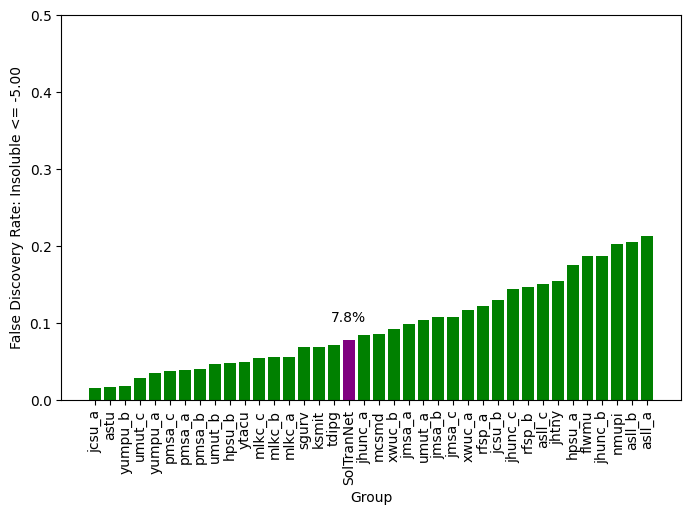

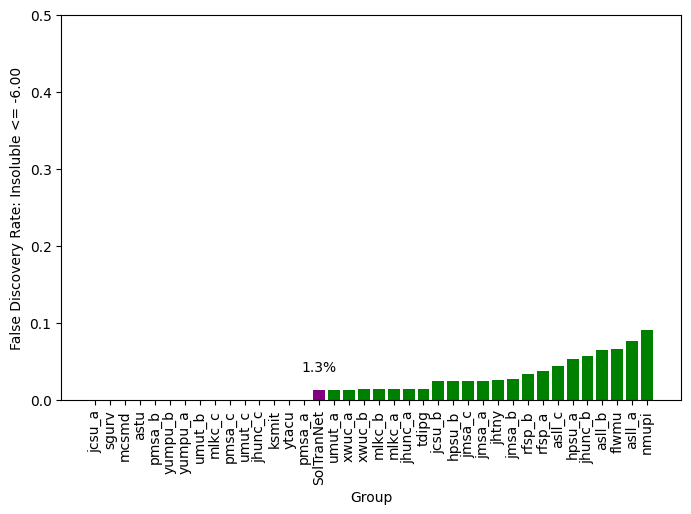

In [141]:
# Initialize plotted_sens flag
plotted_sens = False

for val in data:
    for k in data[val]:
        # Check if the key is 'hit'
        if k == 'hit':
            if plotted_sens:
                continue
            
            fig = plt.figure(figsize=(8, 5))
            # Sort the data based on sensitivity in descending order
            all_data = sorted(data[val][k], key=lambda x: x[1], reverse=True)
            plt.ylabel('Sensitivity')
        else:
            # Create a new figure
            fig = plt.figure(figsize=(8, 5))
            # Sort the data based on false discovery rate in ascending order
            all_data = sorted(data[val][k], key=lambda x: x[1])
            plt.ylabel(f'False Discovery Rate: Insoluble <= {val:.2f}')
            plt.ylim((0, 0.5))

        # Extract labels and values from sorted data
        labels = [x[0] for x in all_data]
        ys = [x[1] for x in all_data]
        x_pos = np.arange(len(all_data))
        colors = ['purple' if x[0] == 'SolTranNet' else 'green' for x in all_data]
        
        # Plot the bar chart
        bars = plt.bar(x_pos, ys, color=colors)

        # Annotate SolTranNet bar with its percentage value
        for i, bar in enumerate(bars):
            if labels[i] == 'SolTranNet':
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{ys[i]*100:.1f}%', ha='center', va='bottom')
        
        plt.xlabel('Group')
        plt.xticks(x_pos, labels, rotation='vertical')
        
        # Save the figure
        plt.savefig(f'../figures/False Discovery Rate: Insoluble <= {val:.2f}.png')
        
        # Set plotted_sens to True to avoid creating multiple sensitivity plots
        plotted_sens = True


- From the publication, SolTranNet had a sensitivity value of **94.8%** which is the same as the one reproduced in the first plot above.
- The false discovery rate for compounds with log solubility of <= 4 is also as found on the publication to be **28.6%**

## Conclusion
The reproducibility of the SolTranNet model has been successful as shown by the plots made in this notebook as well as the specific values obtained.

